In [103]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from matplotlib import colors
import glob
from mpl_toolkits.mplot3d import Axes3D


# ------ LOAD THE DATA ------ #
dir = './output_new_new/3d'
# dir = './outputs_new/3d_data/3d'
# --------------------- evacuation data --------------------- #
evacfiles = [f"{dir}/1000/gy-evac 3d-table.csv", 
             f"{dir}/5000/gy-evac 3d-table.csv", 
             f"{dir}/10000/gy-evac 3d-table.csv",
             f"{dir}/15000/gy-evac 3d-table.csv"]
evacdata_list = [pd.read_csv(file, skiprows=6) for file in evacfiles]
# concatenate the dataframes
evacdata = pd.concat(evacdata_list, ignore_index=True).sort_values(by=['initial-people', 'evacuation-probability', 'ticks']).reset_index(drop=True)
# rename the columns to something not cursed
evacdata.rename(columns={'[run number]': 'run_number'}, inplace=True)
evacdata.columns = evacdata.columns.str.replace('-', '_')
evacdata.rename(columns={'evacuation_probability': 'evp'}, inplace=True)
evacdata.rename(columns={'initial_people': 'population'}, inplace=True)
# calculate time in minutes
evacdata['time_minutes'] = evacdata['ticks'] * evacdata['tick_time_in_mins']

# ------------------ journey metrics ------------------ #
jm_dirs = [f"{dir}/1000", f"{dir}/5000", f"{dir}/10000", f"{dir}/15000"]
jm_files = [file for sublist in [glob.glob(f"{d}/jm*.csv") for d in jm_dirs] for file in sublist]
jm_list = [pd.read_csv(file) for file in jm_files]
# extract the evacuation proobability and population from the filename
for i, file in enumerate(jm_files):
    evp = float(file.split('/')[-1].split('_')[3][3:])  # evac prob
    pop = int(file.split('/')[-1].split('_')[2][1:])  # population
    jm_list[i]['evp'] = evp
    jm_list[i]['population'] = pop
    
journey_metrics = pd.concat(jm_list, ignore_index=True).sort_values(by=['population', 'evp', 'start_tick']).reset_index(drop=True)# calculate normalised journey time
journey_metrics['normalised_journey_time'] = journey_metrics['actual_time'] / journey_metrics['ideal_time']
# calculate time in minutes
journey_metrics['start_time_minutes'] = journey_metrics['start_tick'] * 0.3 # 1 tick = 0.3 mins


In [94]:
evacdata.head()

,run_number,terminate_evac_distance_km,population,max_walking_distance_km,warning_interval_time_mins,evp,tick_time_in_mins,over_break_probability,[step],ticks,get_no_active_cars,get_no_walking,get_no_evacuating,get_no_evacuated,get_no_in_cars,get_avg_no_people_per_car,time_minutes
0,1,0.3,1000,1,30,0.1,0.3,0.06,0,0,0,0,0,0,0,0.000000,0.0
1,1,0.3,1000,1,30,0.1,0.3,0.06,1,1,76,4,85,0,81,1.065789,0.3
2,1,0.3,1000,1,30,0.1,0.3,0.06,2,2,76,4,85,0,81,1.065789,0.6
3,1,0.3,1000,1,30,0.1,0.3,0.06,3,3,76,4,85,0,81,1.065789,0.9
4,1,0.3,1000,1,30,0.1,0.3,0.06,4,4,76,4,85,0,81,1.065789,1.2


In [95]:
journey_metrics.head()

,car_id,passengers,ideal_time,actual_time,start_tick,end_tick,evp,population,normalised_journey_time,start_time_minutes
0,828,1,0.011375,1.8,0,6,0.1,1000,158.241758,0.0
1,22552,1,0.012188,2.1,0,7,0.1,1000,172.307692,0.0
2,4632,1,0.012156,2.7,0,9,0.1,1000,222.107969,0.0
3,25144,1,0.015187,2.7,0,9,0.1,1000,177.777778,0.0
4,11772,1,0.021885,3.0,0,10,0.1,1000,137.077582,0.0


In [96]:
# get data to plot 3D graph

# get the number of people evacuated at 6 hours
evacuated_at_6hours = evacdata[evacdata['time_minutes'] == 360].groupby(['population', 'evp'])['get_no_evacuated'].sum().reset_index()
evacuated_at_6hours.rename(columns={'get_no_evacuated': 'evac_after_6hrs'}, inplace=True)
evacuated_at_6hours

# calculate the percentage of people evacuated at 6 hours for each population
evacuated_at_6hours['perc_evacuated'] = evacuated_at_6hours['evac_after_6hrs'] / evacuated_at_6hours['population'] * 100

# get the average normalised journey time at in the first 6 hours
av_6hr_norm_jm = journey_metrics[journey_metrics['start_time_minutes'] < 360].groupby(['population', 'evp'])['normalised_journey_time'].mean().reset_index()
av_6hr_norm_jm.rename(columns={'normalised_journey_time': 'av_6hr_njt'}, inplace=True)

# merge the two dataframes
data_3d = pd.merge(av_6hr_norm_jm, evacuated_at_6hours, on=['population', 'evp'])


data_3d.head()

,population,evp,av_6hr_njt,evac_after_6hrs,perc_evacuated
0,1000,0.1,404.855928,730,73.00
1,1000,0.2,599.524616,937,93.70
2,1000,0.3,798.439145,987,98.70
3,1000,0.4,1042.893695,995,99.50
4,5000,0.1,3356.216541,2922,58.44


In [ ]:
# plot the 3D graph: 6hr evacuated vs population & evp

fig = plt.figure()
ax = fig.gca(projection='3d')
ax.plot_trisurf(data_3d['population'], data_3d['evp'],  data_3d['evac_after_6hrs'], cmap=plt.cm.jet, linewidth=0.01)
ax.view_init(30, 45)
ax.set_xlabel('Initial People')
ax.set_ylabel('Evacuation Probability')
ax.set_zlabel('No. people evacuated')
ax.invert_yaxis()
ax.invert_xaxis()
plt.show()

Text(0.5,0,'% People Evacuated')

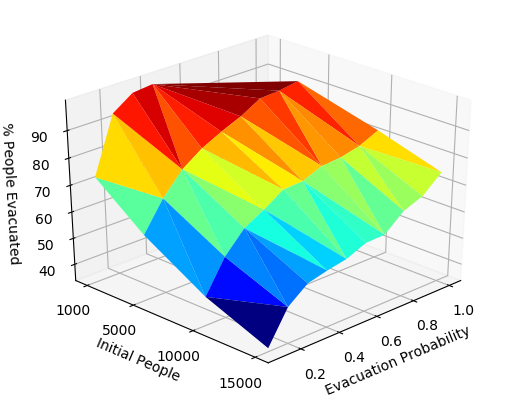

In [97]:
# plot the 3D graph: 6hr percentage evacuated vs population & evp

fig = plt.figure()
ax = fig.gca(projection='3d')
ax.plot_trisurf(data_3d['evp'], data_3d['population'],  data_3d['perc_evacuated'], cmap=plt.cm.jet, linewidth=0.01)
ax.view_init(30, 45)
ax.set_ylabel('Initial People')
ax.set_xlabel('Evacuation Probability')
#ax.set_zlabel('% people evacuated')
#ax.invert_yaxis()
ax.invert_xaxis()
ax.set_yticks([1000, 5000, 10000, 15000])
ax.set_zlabel('% People Evacuated', rotation=180) # idk why rotation is not working
#plt.show()

Text(0.5,0,'Av. Normalised Journey Time')

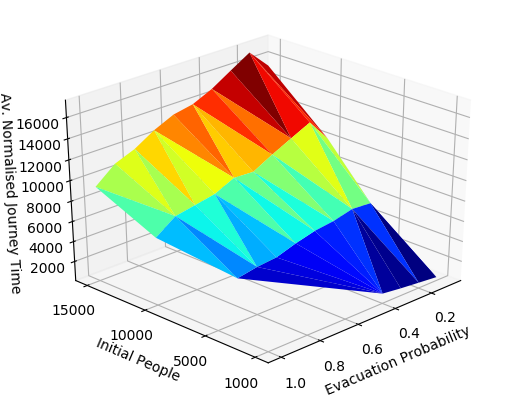

In [104]:
# plot the 3D graph: 6hr percentage evacuated vs population & evp

fig = plt.figure()
ax = fig.gca(projection='3d')
ax.plot_trisurf(data_3d['evp'], data_3d['population'],  data_3d['av_6hr_njt'], cmap=plt.cm.jet, linewidth=0.01)
ax.view_init(30, 45)
ax.set_ylabel('Initial People')
ax.set_xlabel('Evacuation Probability')
#ax.set_zlabel('% people evacuated')
ax.invert_yaxis()
#ax.invert_xaxis()
ax.set_yticks([1000, 5000, 10000, 15000])
ax.set_zlabel('Av. Normalised Journey Time', rotation=180) # idk why rotation is not working
#plt.show()

Text(0.5,0,'Av. Normalised Journey Time')

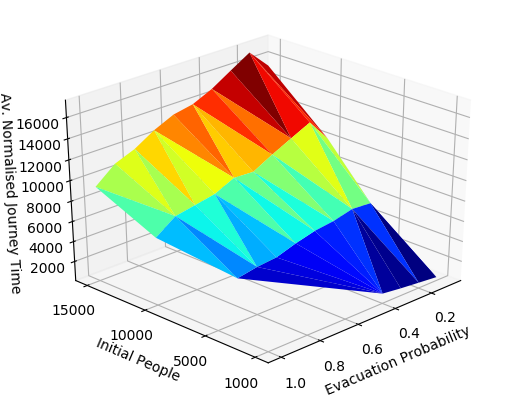

In [ ]:
# plot the 3D graph: 6hr percentage evacuated vs population & evp

fig = plt.figure()
ax = fig.gca(projection='3d')
ax.plot_trisurf(data_3d['evp'], data_3d['population'],  data_3d['av_6hr_njt'], cmap=plt.cm.jet, linewidth=0.01)
ax.view_init(30, 45)
ax.set_ylabel('Initial People')
ax.set_xlabel('Evacuation Probability')
#ax.set_zlabel('% people evacuated')
ax.invert_yaxis()
#ax.invert_xaxis()
ax.set_yticks([1000, 5000, 10000, 15000])
ax.set_zlabel('Av. Normalised Journey Time', rotation=180) # idk why rotation is not working
#plt.show()

### NOTE

Note the y and y axes are inverted from % people evacuated and normalised journey time for visual clarity

In [ ]:
# plotting the timeseries 